In [10]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(2)

def random_move(position, class_size, a): # l w
    x, y = position
    x = x + a*np.cos(2*np.pi*random.random())
    y = y + a*np.sin(2*np.pi*random.random())
    return x, y
        

def rand_initialize(num_people, class_size):
    '''
    sp: Student id and their corresponding position
    '''
    sp={}
    for i in range(num_people):
        sp[i] = []
        sp[i].append(np.array([random.randint(1, class_size), random.randint(1, class_size)]))
    return sp

        
def assign_infection(l, prob_infected):
    num_infected = int(prob_infected*len(l))
    form = {}
    infected = random.sample(l, k=num_infected)
    safe = []
    for i in range(len(l)):
        if l[i] not in infected:
            safe.append(l[i])
    for i in range(len(l)):
        form[l[i]] = []
    for i in infected:
        form[i].append('infected')
    for j in safe:
        form[j].append('safe')
    return form
        

class_size=[1000, 1000] #m^2
num_people=100
people = rand_initialize(num_people, class_size[0])
names = []
for i in people:
    names.append(i)

    
def infected_list(infected_dict):
    inf = []
    for k in infected_dict:
        if infected_dict[k][0] == 'infected':
            inf.append(int(k))
    return inf

def prob(k, po, D):
    return po*np.e**(-k*D)

# def probability(status):
#     proba = 
#     return max(proba_list)/len(names)


deltat = 1 # min
T = 20 # min
positions = {}
status = {} 
d = {}
dmax = 2 #m
k = 1/dmax
po = 1
new_status = {}
infected = []
time = []
probability_of_getting_infected = {}
a = 0.1 #m
proba_infection=0.05
probability_threshold = 0.2

infected_dict = assign_infection(names, proba_infection)
inf = infected_list(infected_dict)
for t in range(0, T, deltat):
    positions[str(t+1)] = []
    status[str(t+1)] = []
for t in range(0, T, deltat):
    for j in people:
        x, y = random_move(people[j][0], class_size, a) # random move
        positions[str(t+1)].append([x, y])
        # move with some proba - assumed to be uniform
        status[str(t+1)].append(infected_dict[j])
    for i in inf:
        for p in positions:
            d['person_id: ' + str(i) + ', ' + 'time_interval: ' + p] = []
            for j in positions[p]:
                  d['person_id: ' + str(i) + ', ' + 'time_interval: ' + p].append(round(np.sqrt((j[0] - positions[p][i-1][0])**2 + (j[1] - positions[p][i-1][1])**2), 3))
    for i in d:
        probability_of_getting_infected[i] = []
        for j in d[i]:
            probability_of_getting_infected[i].append(prob(k, po, j))
    
    list_status = [v for _, v in probability_of_getting_infected.items()]
    for i in range(int(len(list_status)/len(inf))):
        new_status[str(i+1)] = []
        for j in range(len(list_status[i])):
            try:
                if list_status[i][j] > probability_threshold and list_status[i+T][j] > probability_threshold:
                    new_status[str(i+1)].append('infected')
                else:
                    new_status[str(i+1)].append('safe')
            except:
                pass
    status = new_status
    infected_dict = assign_infection(names, len(np.unique(inf))/len(names))
    inf = np.unique(inf + infected_list(infected_dict)).tolist()
#    print(inf, len(np.unique(inf))/len(names))
    infected.append(len(inf)/len(names))
    time.append(t+1)

# plt.plot(infected, probability)
    # proba infection
    # update infected   

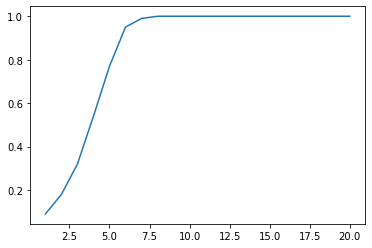

In [11]:
plt.plot(time, infected)

In [ ]:
# Idea: Maintain a certain distance between people initially. Then with some softness, move them with some probability (the distance between them now can be a little less than 3 (reality))
# Then plot the distribution of num_infected vs time

In [25]:
# Can we accomodate these many people in a place
# Assuming them to be almost stationary throughout
def can_accomodate(place_size, dist_norm, air_space_class=[2, 3], air_space_people=1):
    '''
    place_size (list): [length, breadth]
    dist_norm: min_distance between people to be followed
    air_space_people: comfort+size..etc.
    air_space_class (list): class_room size not used [length, breadth]
    '''        
    return int(((place_size[0]-2*air_space_class[0])*(place_size[1]-2*air_space_class[1]))/((air_space_people/2 + dist_norm)**2))
can_accomodate(place_size=[30, 30], dist_norm=2)

99

# Work to be done

In [ ]:
# def random_generate_pos(class_size, num_people):
#     position = []
#     for i in range(num_people):
#         x = random.randint(0, class_size)
#         y = random.randint(0, class_size)
#         position .append([x, y])
#     return position

# position = random_generate_pos(10, 10)

# people = {}
# for i in range(len(position)):
#     people[i] = []
#     people[i].append(np.array(position[i]))

# names = []
# for i in people:
#     names.append(i)


# def random_move(position, a): # l w
#     x, y = position
#     x = x + a*np.sin(2*np.pi*random.random())
#     y = y + a*np.sin(2*np.pi*random.random())
#     return x, y

# def assign_infection(l, prob_infected):
#     num_infected = int(prob_infected*len(l))
#     form = {}
#     infected = random.sample(l, k=num_infected)
#     safe = []
#     for i in range(len(l)):
#         if l[i] not in infected:
#             safe.append(l[i])
#     for i in range(len(l)):
#         form[l[i]] = []
#     for i in infected:
#         form[i].append('infected')
#     for j in safe:
#         form[j].append('safe')
#     return form

# def infected_list(infected_dict):
#     inf = []
#     for k in infected_dict:
#         if infected_dict[k][0] == 'infected':
#             inf.append(int(k))
#     return inf

# def prob(k, po, D):
#     return po*np.e**(-k*D)

# class Model:
#     def __init__(self, names, frac_infected):
#         self.names = names
        
#         pass    
#     def crux(self, T, deltat, frac_infected, probabiity_threshold, class_size, a):
#         positions = {}
#         status = {} 
#         d = {}
#         new_status = {}
#         infected = []
#         time = []
#         probability_of_getting_infected = {}
#         infected_dict = assign_infection(self.names, frac_infected)
#         inf = infected_list(infected_dict)
#         for t in range(0, T, deltat):
#             positions[str(t+1)] = []
#             status[str(t+1)] = []        
#         for t in range(0, T, deltat):
#             for j in people:
#                 x, y = random_move(people[j][0], a) # random move
#                 positions[str(t+1)].append([x, y])
#                 # move with some proba - assumed to be uniform
#                 status[str(t+1)].append(infected_dict[j])
#             for i in inf:
#                 for p in positions:
#                     d['person_id: ' + str(i) + ', ' + 'time_interval: ' + p] = []
#                     for j in positions[p]:
#                           d['person_id: ' + str(i) + ', ' + 'time_interval: ' + p].append(round(np.sqrt((j[0] - positions[p][i-1][0])**2 + (j[1] - positions[p][i-1][1])**2), 3))
#             for i in d:
#                 probability_of_getting_infected[i] = []
#                 for j in d[i]:
#                     probability_of_getting_infected[i].append(prob(1, 1, j))

#             list_status = [v for _, v in probability_of_getting_infected.items()]
#             for i in range(int(len(list_status)/len(inf))):
#                 new_status[str(i+1)] = []
#                 for j in range(len(list_status[i])):
#                     try:
#                         if list_status[i][j] > probability_threshold and list_status[i+T][j] > probability_threshold:
#                             new_status[str(i+1)].append('infected')
#                         else:
#                             new_status[str(i+1)].append('safe')
#                     except:
#                         pass
#             status = new_status
#             # proba_infection = len(np.unique(inf))/len(names)
#             infected_dict = assign_infection(names, len(np.unique(inf))/len(names))
#             inf = np.unique(inf + infected_list(infected_dict)).tolist()
#             print(inf, len(np.unique(inf))/len(names))
#             infected.append(len(inf)/len(names))
#             time.append(t+1)
#         return time, infected
#     def plot_trend(self, time, infected):
#         return plt.plot(time, infected)